In [ ]:
import csv # csv reader
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text),training=True),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

In [ ]:
def parse_data_line(data_line):
    # Should return a tuple of the label as just positive or negative and the statement
    # e.g. (label, statement)

    label=data_line[1]
    statement = data_line[2]
    # Check if the label is either "positive" or "negative" and convert it to lowercase
    label = label.strip().lower()
    if label in ("positive", "negative"):
        return (label, statement)
    return (None, None)

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

# Improve the preprocessing. Which tokens might you want to throw out or preserve?
# What about punctuation? Do not forget normalisation, lemmatising, stop word removal - what aspects of this might be useful?
# Think about the features: what could you use other than unigram tokens? It may be useful to look beyond single words to combinations of words or characters.
def generate_ngrams(tokens, n):
    return list(ngrams(tokens, n))

def pre_process(text):
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings

    # Tokenization
    tokens = re.split(r"\s+",text)

    # Lowercasing: Normalize text to lowercase to ensure uniformity in word representations.
    tokens = [t.lower() for t in tokens]

    # Remove stop words:Common English stopwords are removed using NLTK's stopwords.
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]

    # Lemmatization:  reduce words to their base or root form. Eliminate common stop words that may not contribute much to the meaning.
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # using bigrams or trigrams to capture sequences of words.
    unigrams = tokens
    bigrams = generate_ngrams(tokens, 2)
    trigrams = generate_ngrams(tokens, 3)

    all_features = unigrams + bigrams + trigrams

    return all_features

In [ ]:
# Also the feature weighting scheme: what could you do other than using binary values?
# You could add extra stylistic features like the number of words per sentence.
global_feature_dict = {}
def to_feature_vector(tokens, training=False):
    i = 0
    # Stylistic feature: Number of words per sentence
    featureVector = {'0':0}

    for w in tokens:
        try:
            i = global_feature_dict[w]
        except KeyError:
            if training:
                i = len(global_feature_dict) + 1
                global_feature_dict[w] = i
            else:
                i = global_feature_dict["<unk/>"]

        try:
            featureVector[str(i)] += 1
        except KeyError:
            featureVector[str(i)] = 1

    featureVector['0'] = len(featureVector)
    return featureVector
global_feature_dict["<unk/>"] = len(global_feature_dict)+1

In [ ]:
def train_classifier(data, c=1.0, class_weight=None):
    """
    Train a LinearSVC classifier using scikit-learn.

    Parameters:
    - data: Training data in the required format for NLTK classifiers.
    - c: Cost parameter for the SVM (default is 1.0).
    - class_weight: Weights associated with classes (default is None).

    Returns:
    - Trained classifier.
    """
    print("Training Classifier...")

    # Customize the SVM classifier with parameters
    # Cost Parameter (C): Adjust the cost parameter to control the trade-off between achieving a smooth decision boundary and classifying training points correctly.
    # Class Weights: Experiment with assigning different weights to classes, especially in imbalanced datasets.
    svm_classifier = LinearSVC(C=c, class_weight=class_weight, dual=False)
    pipeline = Pipeline([('svc', svm_classifier)])

    # Train the classifier using NLTK's SklearnClassifier
    return SklearnClassifier(pipeline).train(data)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def cross_validate(dataset, folds):
    results = []
    all_accuracy = []
    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE

        # create training and test data for each fold
        test_start = i
        test_end = min(i + fold_size, len(dataset))
        test_set = dataset[test_start:test_end]
        train_set = dataset[:test_start] + dataset[test_end:]

        # Make use of the given functions train_classifier() and predict_labels() to do the cross-validation
        # train the classifier on the larger training part, and test on the smaller test part.
        classifier = train_classifier(train_set, c=0.5, class_weight='balanced')

        test_true = [t[1] for t in test_set]
        test_pred = predict_labels([x[0] for x in test_set], classifier)

        # get the precision, recall, f1 score, and accuracy of classifier in a variable cv_results, which should contain average scores for all folds and be returned by this function
        report = classification_report(test_true, test_pred, output_dict=True)
        results.append(report)
        print(report)

In [ ]:
def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(pre_process(sample)))

In [ ]:
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset

data_file_path = '/content/drive/MyDrive/nlp/sentiment-dataset.tsv'

print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
613189


In [ ]:
cross_validate(train_data, 10)

Fold start on items 0 - 2684
Training Classifier...
{'negative': {'precision': 0.8249641319942611, 'recall': 0.7029339853300733, 'f1-score': 0.759075907590759, 'support': 818}, 'positive': {'precision': 0.8777050830397585, 'recall': 0.9346195069667739, 'f1-score': 0.9052686218531015, 'support': 1866}, 'accuracy': 0.8640089418777943, 'macro avg': {'precision': 0.8513346075170098, 'recall': 0.8187767461484237, 'f1-score': 0.8321722647219303, 'support': 2684}, 'weighted avg': {'precision': 0.8616312760519728, 'recall': 0.8640089418777943, 'f1-score': 0.8607136143022088, 'support': 2684}}
Fold start on items 2684 - 5368
Training Classifier...
{'negative': {'precision': 0.7389473684210527, 'recall': 0.5919055649241147, 'f1-score': 0.6573033707865168, 'support': 593}, 'positive': {'precision': 0.8904481665912177, 'recall': 0.9406982305117169, 'f1-score': 0.9148837209302326, 'support': 2091}, 'accuracy': 0.8636363636363636, 'macro avg': {'precision': 0.8146977675061352, 'recall': 0.7663018977

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Training Classifier...


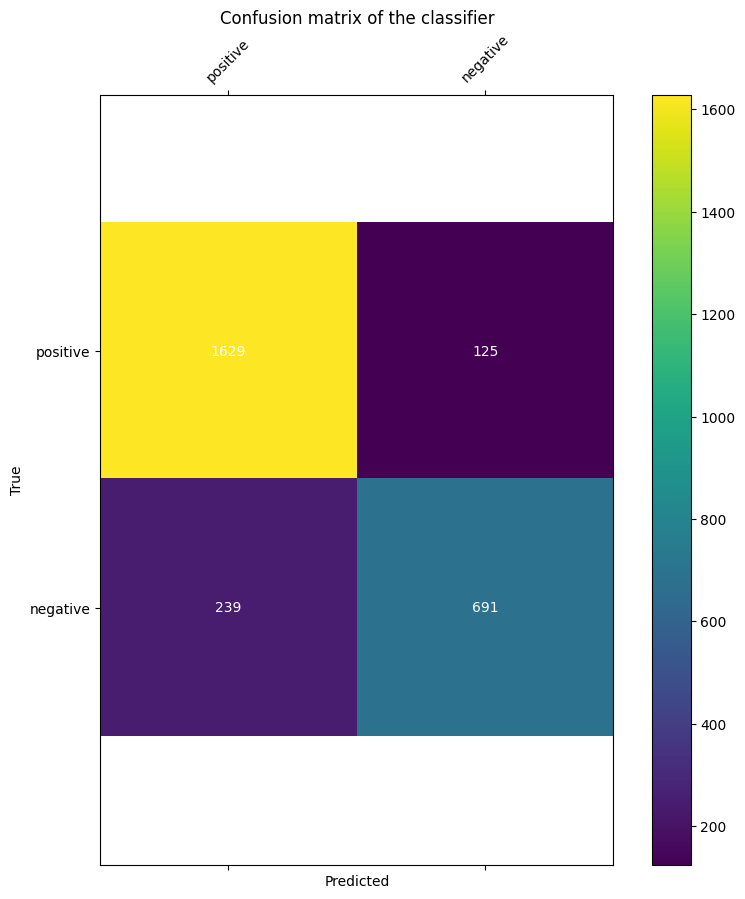

In [ ]:
train_train_data=[]
train_test_data=[]
labels=["positive", "negative"]
num_samples = len(train_data)
num_training_samples = int((0.9 * num_samples))
for (text, label) in train_data[:num_training_samples]:
    train_train_data.append((text,label))
for (text, label) in train_data[num_training_samples:]:
    train_test_data.append((text,label))

classifier = train_classifier(train_train_data)
train_test_true = [t[1] for t in train_test_data]
train_test_pred = predict_labels([x[0] for x in train_test_data], classifier)
confusion_matrix_heatmap(train_test_true, train_test_pred, labels)

In [ ]:
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'0': 16, '220': 1, '4': 2, '3676': 1, '280283': 1, '212': 1, '1': 23, '225': 2, '422': 1, '165218': 1, '12305': 1, '8799': 1, '96096': 1, '1167': 1, '29268': 1, '514502': 1}, 'positive')
Training Classifier...
Done training!
Precision: 0.854755
Recall: 0.852564
F Score:0.847246
